In [17]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

In [23]:
"""
次のコードは、一般化されたドイチ-ジョサのオラクルを作成し、量子ゲートに変換する関数です。
caseで分布型か定値型かを区別し（'balanced'または constant）、また nは入力レジスターのサイズです
"""
def dj_oracle2(n, b_str):
    if n%2 != 0:
        raise Exception("b_str must be even-strings")
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)

    # b_strが正しい文字列か検証する
    zero, one = 0, 0
    for c in b_str:
        if c=="1":
            one += 1
        elif c=="0":
            zero += 1
        else:
            raise Exception("b_str must consist of 1 or 0.")

    if (zero!=0 and one!=0) and zero != one:
        raise Exception("b_str is expected balanced, but not balanced.")

    # balanced か constant か？
    if zero==n:
        case = "constant0"
    elif one==n:
        case = "constant1"
    else:
        case = "balanced"

    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # We place the first X-gates. Each digit in our binary string
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the CNOT gates for each qubit, using the output qubit
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    elif case == "constant0":
        pass
    elif case == "constant1":
        oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    print(case)
    return oracle_gate

In [24]:
"""
このオラクルのゲートを入力して、ドイチ-ジョサのアルゴリズムを実行する関数も作成する。
"""
def dj_algorithm2(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

constant1


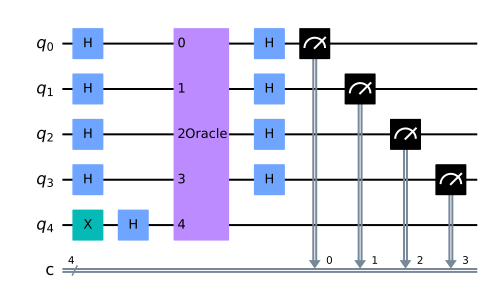

In [60]:
"""
ドイチュ・ジョサのアルゴリズムを回路に結合する
"""
n = 4
oracle_gate = dj_oracle2(n, "1111")
dj_circuit = dj_algorithm2(oracle_gate, n)
dj_circuit.draw()

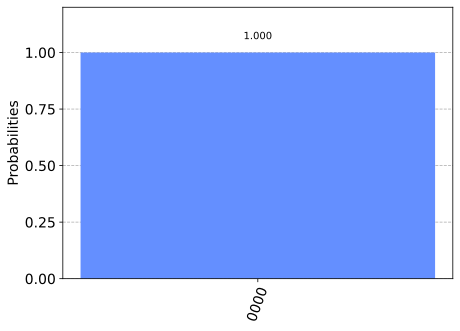

In [61]:
"""
回路を実行する

定置型のとき、|00...0>になる
分布型のとき、|00...0>にはならない（直行する状態になる）
"""
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)